# D7041E Lab 1 - Neural Networks (MNIST)
    Alexander Mennborg
    Niklas Lundberg

In [0]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import random
from math import sqrt
from PIL import Image
from matplotlib import pyplot as plt
from keras.datasets import mnist

# If the dataset image file is not preset, download it
if not os.path.isfile('dataset_processed.jpg'):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1J9Ok4KbtpYZ4HrOgsvL2fsKB_H7Vczkd' -O 'dataset_processed.jpg'


Using TensorFlow backend.


## 1.1 Import your dataset into Jupyter environment
### 1.1.1 Make an array containing all the samples of your dataset
For our own dataset we have drawn a 5 different shapes 5 times each on a piece of paper.
Then we took a photo of the paper and grouped the shapes into one smaller picture and applied filters to reduce noise and also we made the image grayscale. We have also scaled down the image to make each shape 28 by 28 pixels large.

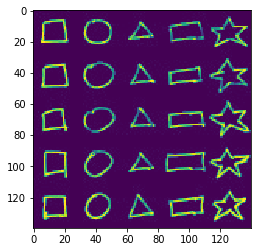

In [0]:
img = Image.open("dataset_processed.jpg", "r").convert("L")
img_array = np.array(img)
plt.imshow(img_array)
del img_array

Now we have loaded the image containing the dataset. Next step is to split the image it into `5 * 5 = 25` images each `28` by `28` pixels. The result is stored in a 3D array where the first dimension is the image from 0 through 24 and the other dimensions are for the image values.

In [0]:
dataset = np.zeros((25, 28, 28)) # (n, x, y, 1) array (n samples, x coord, y coord, 1 grayscale)
labels = ['square', 'circle', 'triangle', 'rectangle', 'star'] * 5
for i in range(0, 5):
    for j in range(0, 5):
        region = (i * 28, j * 28, (i + 1) * 28, (j + 1) * 28)
        cropped = img.crop(region)
        dataset[i + j * 5] = np.array(cropped)
        
print("Tensor shape: " + str(dataset.shape))

Tensor shape: (25, 28, 28)


### 1.1.2 Write a function to plot a sample
We also plotted the entire dataset by looping through all samples and plotting each.

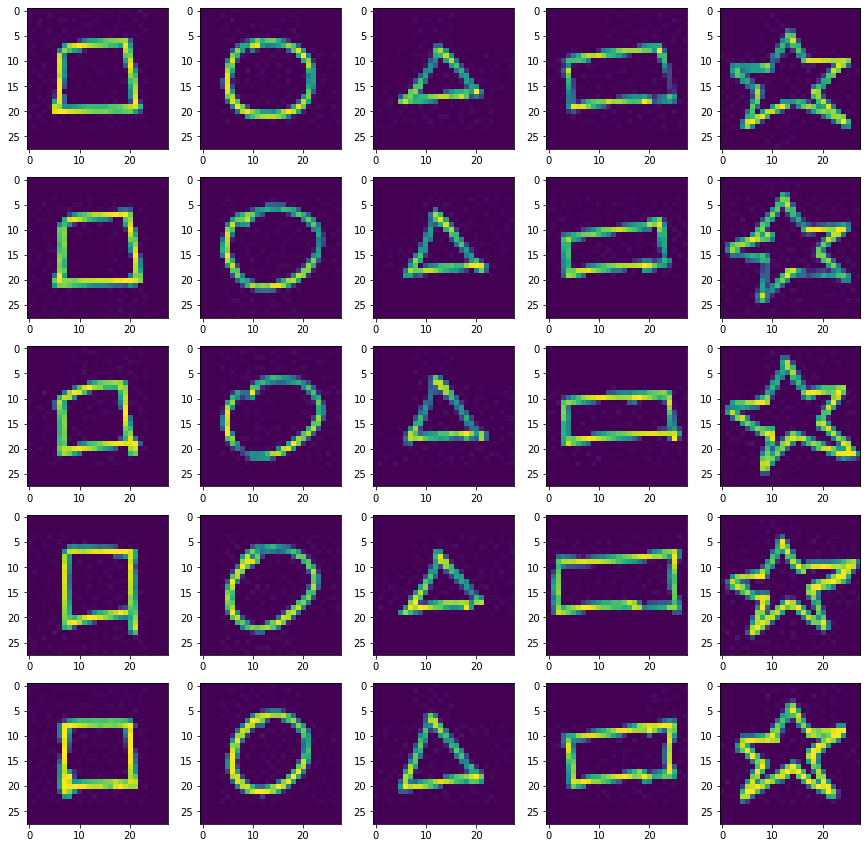

In [0]:
def plot_sample(i):
    plt.imshow(dataset[i])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
for i in range(0, 25):
    plt.subplot(5, 5, i + 1)
    plot_sample(i)

### 1.1.3 For a given sample plat the distribution of values accross all features
We choose the plot sample 4 which is the star shape and simply loop through every other shape and find out the minimum, maximum, mean and standard deviation values.

Sample 4


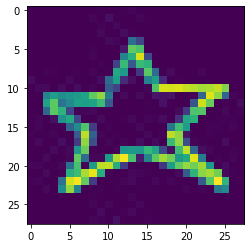

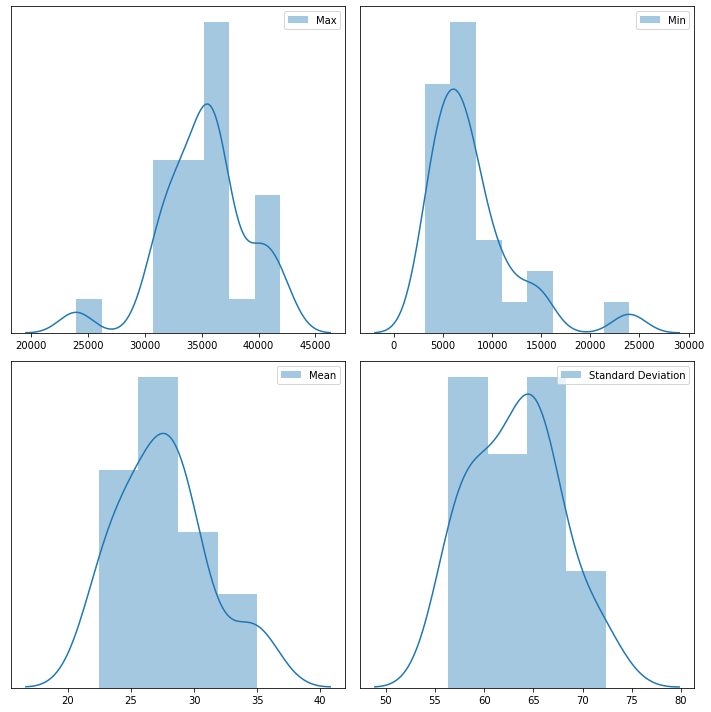

In [0]:
num_samples = dataset.shape[0]
target = dataset[4]
print("Sample " + str(4))
plot_sample(4)

def compare_imgs(this, other):
    data = np.zeros(4) # [min, max, mean, stdev]
    pixels = this.shape[0]*this.shape[1]*2 # pixels in both images combined
    for i in range(this.shape[0]):
        for j in range(this.shape[1]):
            data[0] += np.minimum(this[i, j], other[i, j])
            data[1] += np.maximum(this[i, j], other[i, j])
            data[2] += this[i, j] + other[i, j]
    data[2] /= pixels
    
    for i in range(this.shape[0]):
        for j in range(this.shape[1]):
            data[3] += (this[i, j] - data[2]) ** 2
            data[3] += (other[i, j] - data[2]) ** 2
    data[3] = sqrt(data[3]/pixels)
    return data

min_vals = []
max_vals = []
mean_vals = []
stdev_vals = []
indices = []
for i in range(dataset.shape[0]):
    data = compare_imgs(target, dataset[i])
    min_vals.append(data[0])
    max_vals.append(data[1])
    mean_vals.append(data[2])
    stdev_vals.append(data[3])
    indices.append(i)
    
    
plt.show()
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
sns.distplot(max_vals, label='Max', ax=axs[0, 0])
axs[0, 0].legend(['Max'])
sns.distplot(min_vals, label='Min', ax=axs[0, 1])
axs[0, 1].legend(['Min'])
sns.distplot(mean_vals, label='Mean', ax=axs[1, 0])
axs[1, 0].legend(['Mean'])
sns.distplot(stdev_vals, label='Standard Deviation', ax=axs[1, 1])
axs[1, 1].legend(['Standard Deviation'])

plt.setp(axs, yticks=[])
plt.tight_layout()

## 2.1 K-Nearest Neighbor Classifier
### 2.1.1 1-NN Classifier using L1 norm
First we load the MNIST dataset into train and test tensors.
Then define the train and test batches with 500 samples. For using L1 norm, we compare two images (the train and test images) by adding all of the absoluate distances and pick the train label that corresponds to the lowest distance.

Train tensor shape: (60000, 28, 28)


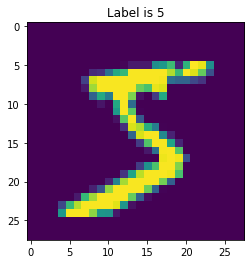

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("Train tensor shape: " + str(x_train.shape))
img = x_train[0,:,:]
label = y_train[0]
plt.title('Label is {Label}'.format(Label=label))
plt.imshow(img)
plt.show()
plt.close()


In [0]:
def training_batch(num_samples): # Batch is a tuple containing (images[], labels[])
    x_set = x_train[:num_samples, :, :]
    return x_set.reshape(num_samples, x_set.shape[1]*x_set.shape[2]), y_train[:num_samples]
    
def testing_batch(): # Test batch is simply an array of images
    return x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
    
def L1_norm(train, test):
    return np.sum(np.abs(train - test), axis=1)

# norm is the function to use for calculating either L1 or L2 norm
def predict(norm, train, labels, test): # Calculates predictions for norm function
    num_test = test.shape[0]
    predictions = np.zeros(num_test, dtype=labels.dtype)
    for i in range(num_test):
        distances = norm(train, test[i, :])
        min_index = np.argmin(distances)
        predictions[i] = labels[min_index]
    return predictions

In [0]:
train_images, train_labels = training_batch(1500)
test_images = testing_batch()
predictions = predict(L1_norm, train_images, train_labels, test_images)
print("L1 norm accuracy:", np.mean((predictions == y_test)))

L1 norm accuracy: 0.281


### 2.1.2 1-NN Classifier using L2 norm
Using L2 norm, we compare images by finding the Euclidean distance between the train and test image.

In [0]:
def L2_norm(train, test):
    return np.sqrt(np.sum(np.square(train - test), axis=1))

predictions = predict(L2_norm, train_images, train_labels, test_images)
print("L2 norm accuracy:", np.mean((predictions == y_test)))

L2 norm accuracy: 0.2196


### 2.1.3 Fixing bug in the NN Classifiers on 2.1.1 and 2.1.2
The accuracy of the L1 and L2 norm is very low and this is due to a bug in the both functions `predict_L1_norm` and `predict_L2_norm`. The reason for this is that the types of the image ndarrays are uint8 which will overflow at values above 255. There is also a problem regarding the unsigned part of the number since we do subtraction it will underflow in some cases. We cast the image array into an array of float32 values, this works for both L1 and L2 norms but int32 would also work on only L1 norm.

In [0]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
predictions = predict(L1_norm, train_images, train_labels, test_images)
print("L1 norm accuracy:", np.mean((predictions == y_test)))
predictions = predict(L2_norm, train_images, train_labels, test_images)
print("L2 norm accuracy:", np.mean((predictions == y_test)))

L1 norm accuracy: 0.8763
L2 norm accuracy: 0.8896




### 2.1.4 Implement k-Nearest Neighbor Classifier

In [0]:
def has_multiple_max(counters, arg_max):
    max = counters[arg_max]
    num_max = 0 
    for j in range(len(counters)):
        if counters[j] == max:
            num_max += 1
    return num_max > 1


def predict_kNN(norm, k, train, labels, test): # Calculates predictions for norm function
    num_test = test.shape[0]
    predictions = np.zeros(num_test, dtype=labels.dtype)
    for i in range(num_test):
        distances = norm(train, test[i, :])
        min_idxs = np.argpartition(distances, k)
        counters = np.zeros(10, dtype='uint8')
        for j in range(k):           
            idx = labels[min_idxs[j]]
            counters[int(idx)] += 1
        arg_max = np.argmax(counters)
        
        if has_multiple_max(counters, arg_max):
            min_index = np.argmin(distances)
            predictions[i] = labels[min_index]
            #predictions[i] = arg_max
        else:
            predictions[i] = arg_max
    return predictions

In [0]:
k = 3
predictions = predict_kNN(L1_norm, k, train_images, train_labels, test_images)
print("L1 norm accuracy: ", np.mean((predictions == y_test)))
predictions = predict_kNN(L2_norm, k, train_images, train_labels, test_images)
print("L2 norm accuracy: ", np.mean((predictions == y_test)))

L1 norm accuracy:  0.8773
L2 norm accuracy:  0.8923


## 2.2 Hyperparameters and Cross-Fold Validation


In [0]:
def training_folds(num_samples, num_folds): # Batch is a tuple containing (images[], labels[])
    x_set = x_train[:num_samples, :, :]
    x_set = x_set.reshape(num_samples, x_set.shape[1]*x_set.shape[2])
    y_set = y_train[:num_samples]
    fold_size = (int) (num_samples / num_folds)
    x_folds = [None] * num_folds;
    y_folds = [None] * num_folds;
    for i in range(num_folds):
        x_folds[i] = x_set[(i*fold_size):((i + 1)*fold_size)]
        y_folds[i] = y_set[(i*fold_size):((i + 1)*fold_size)]
    return x_folds, y_folds

# Implementation with Cross Fold Validation
def cross_validate(norm, k, train_folds, label_folds):
    num_folds = len(train_folds)
    results = np.zeros(num_folds, dtype='float32')
    for i in range(num_folds):
        validation = train_folds[i]
        training = np.array([[]])
        labels = np.array([])

        for j in range(num_folds):
            if j != i:
                training = np.concatenate((training, train_folds[j])) if training.size else train_folds[j]
                labels = np.concatenate((labels, label_folds[j]))
        
        predictions = predict_kNN(L2_norm, k, training, labels, validation)
        results[i] = np.mean((predictions == label_folds[i]))
    return np.mean(results)

num_folds = 3
x_folds, y_folds = training_folds(1500, num_folds)
best_result = 0
best_k = 1
for k in range(1, 20):
    result = cross_validate(L2_norm, k, x_folds, y_folds)
    if result > best_result:
        best_result = result
        best_k = k


training = np.array([[]])
labels = np.array([])
for j in range(num_folds):
    training = np.concatenate((training, x_folds[j])) if training.size else x_folds[j]
    labels = np.concatenate((labels, y_folds[j]))

print("Best validation:", best_result)
print("Best value of k:", best_k)
predictions = predict_kNN(L2_norm, best_k, training, labels, test_images)
print("Best L2 norm accuracy: ", np.mean((predictions == y_test)))
    

Best validation: 0.20599999
Best value of k: 1
Best L2 norm accuracy:  0.8896
